In [144]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
from matplotlib import pyplot as plt
import nltk
import unicodedata
import re
from nltk.corpus import stopwords
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
#!pip install spacy
#!python -m spacy download en_core_web_sm
#nltk.download('stopwords')
import spacy

%matplotlib inline

In [62]:
df=pd.read_csv("reviewsV2.csv")
df.drop(['Unnamed: 0'],axis=1,inplace=True)
df.head()

,review,class,companyName,companySize,roleName,score
0,AppDynamics community support is really strong...,Positive,Synechron (Information Technology & Services,5001-10,Senior Associate Technology,8
1,Documentation maintained with each version sup...,Positive,Synechron (Information Technology & Services,5001-10,Senior Associate Technology,8
2,Trial product is really good as they provide t...,Positive,Synechron (Information Technology & Services,5001-10,Senior Associate Technology,8
3,In terms of dashboard I believe there is plent...,Negative,Synechron (Information Technology & Services,5001-10,Senior Associate Technology,8
4,Synthetic monitoring part is still complex and...,Negative,Synechron (Information Technology & Services,5001-10,Senior Associate Technology,8


In [63]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160 entries, 0 to 159
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   review       160 non-null    object
 1   class        160 non-null    object
 2   companyName  160 non-null    object
 3   companySize  160 non-null    object
 4   roleName     160 non-null    object
 5   score        160 non-null    int64 
dtypes: int64(1), object(5)
memory usage: 7.6+ KB


In [64]:
df.describe()

,score
count,160.000000
mean,8.531250
std,1.491788
min,3.000000
25%,8.000000
50%,9.000000
75%,10.000000
max,10.000000


In [12]:
df.isnull().sum()

review         0
class          0
companyName    0
companySize    0
roleName       0
score          0
dtype: int64

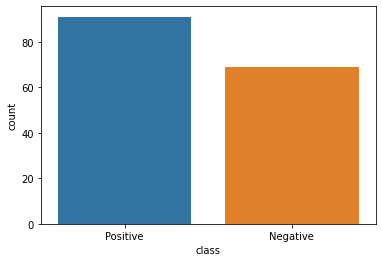

In [105]:
sns.countplot(df['class'])

Defining Class for Data Cleaning functionalities

In [154]:
class PreProcess:
  def __init__(self):
    print("Initialzed")
 
  
  def cleanData( self,text):
    #1.Convert special chars to normal English chars
    review_text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')

    # 2. Remove non-letters        
    letters_only = re.sub("[^a-zA-Z]", " ", review_text) 
    
    # 3.Convert to lower case, split into individual words
    words = letters_only.lower().split()                             
    
    #4.Remove stopWOrds
    stopword_list = nltk.corpus.stopwords.words('english')
    #print(stopword_list)
    stopword_list.remove('no')
    stopword_list.remove('not')
    stopword_list.append('appdynamics')
    clean_text = [w for w in words if not w in stopword_list]   
    
    # 6. Join the words back into one string separated by space, 
    # and return the result.
    final_text=" ".join(clean_text)
    #final_text=self.lemmatize_text(clean_text)
    #print("final_text is",final_text)
    return(final_text) 

  def lemmatize_text(self,text):
    #print("I am here")
    nlp = spacy.load('en_core_web_sm', parse=True, tag=True, entity=True)
    text = nlp(text)
    #print(text)
    text = ' '.join([word.lemma_ if word.lemma_ != '-PRON-' else word.text for word in text])
    return text


 
  

 
  


In [155]:
reviewdf=df[['review','class']]
reviewdf.head()

,review,class
0,AppDynamics community support is really strong...,Positive
1,Documentation maintained with each version sup...,Positive
2,Trial product is really good as they provide t...,Positive
3,In terms of dashboard I believe there is plent...,Negative
4,Synthetic monitoring part is still complex and...,Negative


Calling above function from the PreProcess class to clean the data

In [156]:
# Get the number of reviews based on the dataframe column size
preprocessObj=PreProcess()
totalReviews = reviewdf["class"].size
print(totalReviews)
# Initialize an empty list to hold the clean reviews
cleanReviews = []
for i in range( 0,totalReviews ):
    # clean reviews
    cleanReviews.append(preprocessObj.cleanData(reviewdf["review"][i] ) )

Initialzed
160


Creating sepearte column to store the cleanedReview. It will be useful while creating World Cloud

In [157]:
reviewdf['cleanReviews']=cleanReviews
reviewdf.head()

,review,class,cleanReviews
0,AppDynamics community support is really strong...,Positive,community support really strong even not premi...
1,Documentation maintained with each version sup...,Positive,documentation maintained version support quite...
2,Trial product is really good as they provide t...,Positive,trial product really good provide option runni...
3,In terms of dashboard I believe there is plent...,Negative,terms dashboard believe plenty room improvemen...
4,Synthetic monitoring part is still complex and...,Negative,synthetic monitoring part still complex need a...


Creating Class for Training the model and doing predictions

In [158]:
#Doing Vectorization- Using TfidfVectorizer to convert text data to numbers.
class Train:
  def __init__(self):
    print("Initailzed Train class")
    self.forest=RandomForestClassifier()

  def splitDataset(self,data_features,labels):
    X_train, X_test, y_train, y_test = train_test_split(data_features,labels, test_size=0.2, random_state=10)
    return(X_train,X_test,y_train,y_test)


  def trainModel(self,cleanReviews):
    vectorizer = TfidfVectorizer(max_features=2000)
    data_features = vectorizer.fit_transform(cleanReviews)
    data_features = data_features.toarray()
    print("Datafeatures shape is",data_features.shape)
    labels = reviewdf['class']
    X_train, X_test, y_train, y_test=self.splitDataset(data_features,labels)
    self.setTrainTestData(X_train, X_test, y_train, y_test)
    self.forest = RandomForestClassifier(n_estimators=50)
    self.forest = self.forest.fit(X_train, y_train)
    print(self.forest)
    print(np.mean(cross_val_score(self.forest, data_features, labels, cv=10)))

  def getModel(self):
    return self.forest
  def setTrainTestData(self,X_train, X_test, y_train, y_test):
    self.X_train=X_train
    self.X_test=X_test
    self.y_train=y_train
    self.y_test=y_test




 

Creating Class for Testing the Model. This model inherits the Train Class so that it could use the model object of the base class while doing predictions

In [159]:
class Test(Train):
  def __init__(self):
    self.result=''
  def testModel(self):
    model=self.getModel()
    self.result = model.predict(self.X_test)
    print("Prediction are",self.result)


  

Craeting Object of Test class and calling the respective Training and Testing methods

In [166]:
# Using Random Forest to build model for the classification of reviews.
# Also calculating the cross validation score.
testObj=Test()
testObj.trainModel(cleanReviews)



Datafeatures shape is (160, 623)
RandomForestClassifier(n_estimators=50)
0.70625


In [167]:
testObj.testModel()

Prediction are ['Positive' 'Positive' 'Positive' 'Positive' 'Negative' 'Positive'
 'Negative' 'Negative' 'Positive' 'Negative' 'Negative' 'Positive'
 'Positive' 'Positive' 'Positive' 'Positive' 'Positive' 'Negative'
 'Positive' 'Positive' 'Positive' 'Positive' 'Positive' 'Positive'
 'Negative' 'Negative' 'Negative' 'Positive' 'Positive' 'Positive'
 'Negative' 'Negative']


[[ 8  2]
 [ 3 19]]


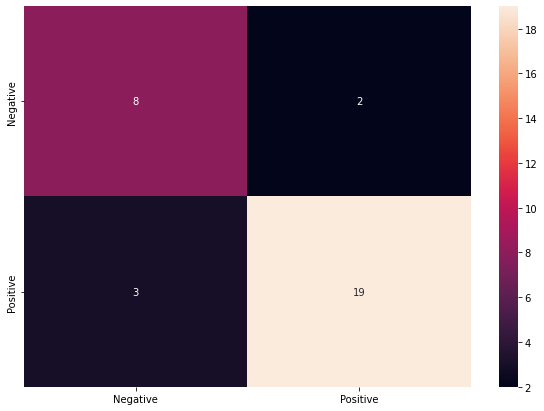

In [168]:
# Print and plot Confusion matirx to get an idea of how the distribution of the prediction is, among all the classes.
conf_mat = confusion_matrix(testObj.y_test, testObj.result)
print(conf_mat)
df_cm = pd.DataFrame(conf_mat, index = [i for i in ['Negative', 'Positive']],
                  columns = [i for i in ['Negative', 'Positive']])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, fmt='g')

Out of total 22 positive reviews 3 reviews are classified as Negative reviews
Out of total 10 negative reviews 2 reviews are classified as Positive 

In [172]:
#Accuracy Metrics
from sklearn.metrics import accuracy_score, confusion_matrix
accuracy = accuracy_score(testObj.y_test,testObj.result)
print("Accuracy of the model is", round(accuracy*100,2) ,"%")

Accuracy of the model is 84.38 %


In [169]:
#Distribution of Test Data
testObj.y_test.value_counts()

Positive    22
Negative    10
Name: class, dtype: int64

In [170]:
newdf=pd.DataFrame()
newdf['original']=testObj.y_test
newdf['predicted']=testObj.result
newdf[newdf['original']=='Positive']

,original,predicted
35,Positive,Positive
132,Positive,Positive
47,Positive,Positive
24,Positive,Positive
90,Positive,Negative
138,Positive,Positive
129,Positive,Negative
58,Positive,Positive
39,Positive,Positive
20,Positive,Positive


Implementing World Cloud

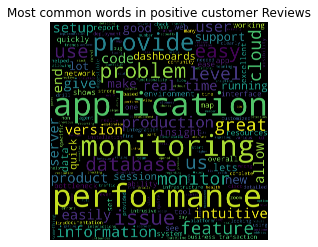

In [171]:
wordcloud = WordCloud(height=5000, width=5000, background_color='black')
wordcloud = wordcloud.generate(' '.join(reviewdf.loc[reviewdf['class']=='Positive','cleanReviews'].tolist()))
plt.imshow(wordcloud)
plt.title("Most common words in positive customer Reviews")
plt.axis('off')
plt.show()

Some  words related to poistive reviews are Performance,Monitoring,easy,information etc

In [ ]:
wordcloud = WordCloud(height=10000, width=10000, background_color='black')
wordcloud = wordcloud.generate(' '.join(reviewdf.loc[reviewdf['class']=='Negative','cleanReviews'].tolist()))
plt.imshow(wordcloud)
plt.title("Most common words in Negative customer Reviews")
plt.axis('off')
plt.show()

In [ ]:
Some  words related to negative reviews are Performance,Monitoring,easy,information etc

However,With ample amount of data ,We could have acheived better result.